# Workshop 1: House Pricing Regression
In this workshop you will need to train a regression neural network to estimate the pricing of houses of California. The main blocks of the workshop are:

- Get the data from PyTorch repository and visualize it.
- Pre-process the data.
- Design the network.
- Train the network.
- Evaluate the model.

[Info of the data](https://www.kaggle.com/datasets/camnugent/california-housing-prices))

In [13]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from torchmetrics import MeanSquaredLogError

torch.manual_seed(12345)

# 1. Get the data (Already in Colab)

In [15]:
TRAIN_DATA_PATH = '/content/sample_data/california_housing_train.csv'
TEST_DATA_PATH = '/content/sample_data/california_housing_test.csv'
TARGET_NAME = 'median_house_value'

In [16]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
test_data = pd.read_csv(TEST_DATA_PATH)

In [17]:
train_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [18]:
train_data.shape, test_data.shape

((17000, 9), (3000, 9))

In [19]:
x_train, y_train = train_data.drop(TARGET_NAME, axis=1), train_data[TARGET_NAME]
x_test, y_test = test_data.drop(TARGET_NAME, axis=1), test_data[TARGET_NAME]

In [20]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((17000, 8), (17000,), (3000, 8), (3000,))

# 2. Pre-process the data.

In [21]:
standard_scaler = StandardScaler()
x_train_scaled = pd.DataFrame(
    standard_scaler.fit_transform(x_train),
    columns=x_train.columns
)
x_test_scaled = pd.DataFrame(
    standard_scaler.transform(x_test),
    columns = x_test.columns
)

In [22]:
x_train_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,2.619365,-0.671520,-1.079671,1.361695,1.764204,-0.361184,-0.075998,-1.252543
1,2.539569,-0.573264,-0.761872,2.296608,3.230441,-0.261865,-0.099404,-1.081483
2,2.494683,-0.905463,-0.920772,-0.882462,-0.866956,-0.955354,-0.999252,-1.170105
3,2.489696,-0.928857,-1.159121,-0.524186,-0.480230,-0.796793,-0.715774,-0.362600
4,2.489696,-0.961609,-0.682422,-0.545747,-0.506328,-0.701830,-0.622148,-1.026454


In [23]:
# Create a PyTorch dataset
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.to_numpy()).float()
        self.y = torch.from_numpy(y.to_numpy()).float()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
train_set = HousingDataset(x_train_scaled[:15000], y_train[:15000])
valid_set = HousingDataset(x_train_scaled[15000:], y_train[15000:])
test_set = HousingDataset(x_test_scaled, y_test)
len(train_set), len(valid_set), len(test_set)

(15000, 2000, 3000)

In [25]:
train_set[0]

(tensor([ 2.6194, -0.6715, -1.0797,  1.3617,  1.7642, -0.3612, -0.0760, -1.2525]),
 tensor(66900.))

In [26]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

In [27]:
len(train_loader)   

235

In [28]:
64*235

15040

In [29]:
next(iter(train_loader))

[tensor([[-8.4180e-01,  1.0971e+00,  9.8602e-01, -8.2053e-01, -8.3137e-01,
          -6.2168e-01, -7.6779e-01, -9.6750e-01],
         [ 6.4940e-01, -6.4813e-01,  5.0932e-01, -7.2786e-02, -2.8805e-01,
          -1.7736e-01, -2.4765e-01,  9.5630e-01],
         [ 1.1381e+00, -6.8088e-01, -2.0572e-01,  2.1209e-01,  1.5087e-01,
          -2.9250e-02,  1.9448e-01, -3.7209e-01],
         [-8.6175e-01,  1.0877e+00, -1.0002e+00, -8.6365e-01, -5.5378e-01,
          -8.6388e-01, -5.7013e-01, -1.6310e+00],
         [-1.1909e+00,  6.9470e-01, -6.0297e-01, -1.1774e-01, -4.3278e-01,
          -4.5005e-01, -4.1669e-01,  2.0190e+00],
         [-1.1909e+00,  4.5608e-01,  2.7098e-01,  2.3319e-01, -8.4014e-02,
          -5.5459e-01, -1.9563e-01,  1.6960e+00],
         [ 6.3942e-01, -7.6510e-01,  6.6822e-01, -3.0858e-01, -6.2661e-02,
           2.1208e-01, -9.6804e-02, -1.2688e+00],
         [-1.1366e-01,  5.2627e-01,  1.8600e+00, -1.0398e+00, -1.0496e+00,
          -7.8372e-01, -1.0539e+00, -1.5112e+00],


# 3. Design the network.

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [31]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = nn.MSELoss()

# 4. Train the network.

In [32]:
def train(epochs=10):
  train_history = []
  valid_history = []
  for epoch in range(epochs):
      running_loss = 0.0
      for i, data in enumerate(train_loader):
          inputs, labels = data
          optimizer.zero_grad()
          outputs = net(inputs)
          loss = criterion(outputs[:, 0], labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()
      train_history.append(running_loss / len(train_loader))
      
      with torch.no_grad():
        running_loss = 0
        for i, data in enumerate(valid_loader):
          inputs, labels = data
          outputs = net(inputs)
          loss = criterion(outputs[:, 0], labels)
          running_loss += loss.item()
        valid_history.append(running_loss / len(valid_loader))

      print('[%d] loss: %.3f, valid_loss: %.3f' % (epoch + 1, train_history[-1], valid_history[-1]))

  plt.plot(train_history)
  plt.plot(valid_history)
  plt.xlabel("Epochs")
  plt.ylabel("MSE")

[1] loss: 23485439581.685, valid_loss: 12971599813.946
[2] loss: 5142113209.191, valid_loss: 7420177656.094
[3] loss: 4390979092.698, valid_loss: 6382673190.778
[4] loss: 4262878686.230, valid_loss: 6497728301.799
[5] loss: 4197789821.821, valid_loss: 6268955402.048
[6] loss: 4157132562.519, valid_loss: 6213357706.527
[7] loss: 4124182102.604, valid_loss: 6033838578.110
[8] loss: 4099197815.285, valid_loss: 6477169621.513
[9] loss: 4074465974.468, valid_loss: 6238174049.979
[10] loss: 4043958292.153, valid_loss: 6321831559.617


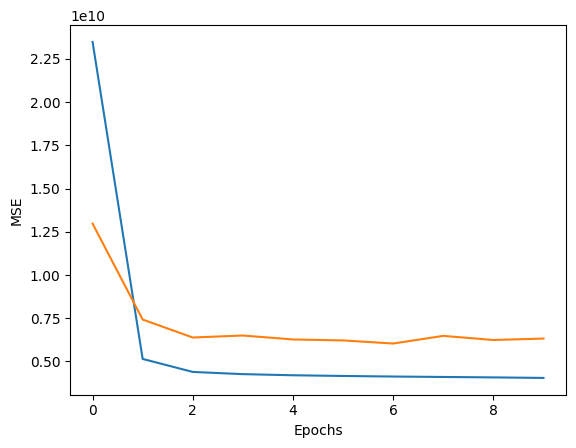

In [33]:
train()

[1] loss: 20.740, valid_loss: 4.662
[2] loss: 1.683, valid_loss: 1.406
[3] loss: 0.539, valid_loss: 0.757
[4] loss: 0.337, valid_loss: 0.566
[5] loss: 0.280, valid_loss: 0.486
[6] loss: 0.249, valid_loss: 0.440
[7] loss: 0.225, valid_loss: 0.409
[8] loss: 0.206, valid_loss: 0.385
[9] loss: 0.189, valid_loss: 0.366
[10] loss: 0.174, valid_loss: 0.348


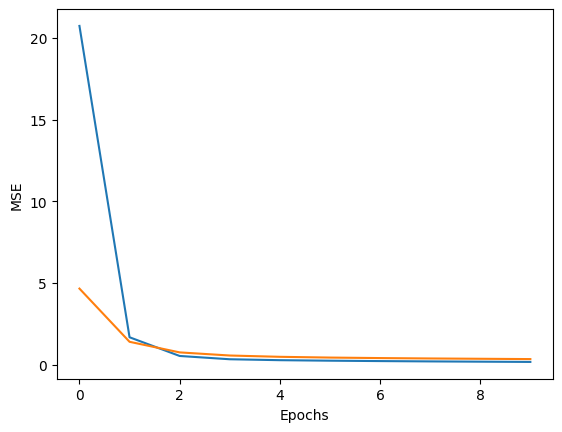

In [34]:
net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.01)
criterion = MeanSquaredLogError()
train()

# Exercise 1: Re-train the model to improve its performance and evaluate it on the test set

In [44]:
# Train the model
train(100)

In [41]:
# predict on the test set 
gt_test = []
preds_test = []

for i, data in enumerate(test_loader):
  with torch.no_grad():
    input, gt = data
    gt_test.append(gt.numpy())
    pred = net(input)
    preds_test.append(pred.numpy()[0][0])

gt_test = np.array(gt_test)
preds_test = np.array(preds_test)

[[314427.40625],
 [178073.234375],
 [262187.1875],
 [326650.25],
 [91548.6328125],
 [55283.16796875],
 [83812.828125],
 [151877.984375],
 [199247.671875],
 [115284.546875],
 [134606.734375],
 [78973.5],
 [226905.65625],
 [208351.46875],
 [267966.25],
 [142962.703125],
 [104103.15625],
 [102063.4765625],
 [329246.625],
 [260282.359375],
 [178192.34375],
 [110629.3203125],
 [199539.453125],
 [138005.921875],
 [129143.578125],
 [364414.46875],
 [159985.515625],
 [333114.0],
 [184666.125],
 [212417.703125],
 [103628.1953125],
 [149549.296875],
 [113666.6171875],
 [258328.03125],
 [233435.078125],
 [139756.859375],
 [159109.0625],
 [265104.78125],
 [164230.890625],
 [200484.421875],
 [105879.1328125],
 [330291.3125],
 [845954.75],
 [82814.28125],
 [226753.859375],
 [225059.734375],
 [236336.140625],
 [156797.53125],
 [163131.328125],
 [194768.4375],
 [185234.6875],
 [78086.390625],
 [149484.0625],
 [172207.59375],
 [206387.859375],
 [231888.515625],
 [129371.7890625],
 [247830.703125],
 [17

In [37]:
# Compare the results with the ground truth
error = np.abs(gt_test - preds_test)
error

In [ ]:
error_pct = (error/gt_test)*100
error_pct, error_pct.mean()